# Project:  **Finding Lane Lines on the Road** 
### Udacity Self Driving  Nanodegree: Term1


### Goals
* Find the lane markers from a driving video and anotate the video to show the lane markings. 


### Reflection
#### The Pipeline
There were two major parts of this project. 
1. Find the lane markings.
2. Generalize the lane markings into a solid line and show them on the video. 

To find the lane markings, I used the following steps:
1. Increase the contrast of the white and yellow colors to highlight the lines.
2. Blurr the image to hide small edges.
3. Apply canny edge detection to find the lines.
3. Eliminate edges outside a region of interest.
5. Find lines using hough transform.

One the lines of the image have been found we have to generalize them to create a continous lines to deliminate the lane. To do this I used the following steps.
1. Converte lines from two points to slope and y intercept.
2. Filter out lines outside the range of resonable slopes for lanes (<.5 and >2)
3. Separate lane markings into a left and right side.
4. Average slopes of lines.
5. Draw lines from top of lane to bottom of picture.

### Possible shortcomings
1. In a few frames of the video one side of the lanes is not seen so no line is shown. 
2. The lines tend to jump around and don't have smooth transitions from one frame to the next.
3. The straign lines can't represent curved lanes.
4. Though not seen in this highway footage, sharp turns would break my approach because both lines could have positive or negative slopes. In this case the average of both lines would be drawn. 

### Improvements
This approach could be improved by time weighting the lines so that past line angles would smooth the possitions of lines between frames. This would also show a line even when a frame didn't pick one up. 

Clustering the hough lines rather than dividing them between possitive slopes would allow for the discovery of the lines during sharp turns. 



In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Image Manipulation Functions

In [2]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def treat_color(img):
    gray_img = grayscale(img)    

    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # define range of color in HSV
    lower_yel = np.array([10,110,200])
    upper_yel = np.array([45,255,255])
    lower_wht = np.array([0,0,230])
    upper_wht = np.array([255,255,255])
    
    # Select yellow and whites whithin desired range
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    
    # Combine yellow and white masks
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 3).astype('uint8')
    
    treated_img = cv2.bitwise_or(subdued_gray, full_mask)
    return treated_img
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lines = get_lines(lines, img_shape=img.shape)

    if lines is not None:
        for line in lines:
            #print(line)
            if line is not None:
                for x1,y1,x2,y2 in line:
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



## Display Function
Helps show multiple pictures at once in a subplot

In [3]:

#helper function to show several images
def show_imgs(img_arr, cmap=None):
    
    fig, ax = plt.subplots(1, img_arr.shape[0], figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})

    axoff = np.vectorize(lambda ax:ax.axis('off'))
    axoff(ax)

    for i, img in enumerate(img_arr):
        ax[i].imshow(img, cmap=cmap)

## Line Functions
Functions to create two solid lines from the many small lines detected from the hough line detection.

In [4]:
def fit_line(line_points):
    """ 
    Given 2 points (x1,y1,x2,y2) compute the line equation
    y = mx + b and return (m, b)
    """
    x1, y1, x2, y2 = line_points
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

def x_intercept(m, b, y=0):
    x = (y - b) / m
    return x
'''
#NOT USED
def y_intercept(m, b, x=0):
    y = m * x + b
    return y

def intersection(m1, b1, m2, b2):
    #intersection point between two lines 
    x = (b2 - b1) / (m1 - m2)
    y = y_intercept(m1, b1, x)
    return x,y
'''
def average_lines(fit_lines):
    m = np.mean([i[0] for i in fit_lines])
    b = np.mean([i[1] for i in fit_lines])
    return m, b

def get_lines(lines, img_shape):
    fit_lines = []
    for line in lines:
        fit_lines.append(fit_line(line[0]))
                     
    fit_lines = sorted(fit_lines, key=lambda x: x[0])
    
    left_line = []
    right_line = []
    min_m = .1
    max_m = 2.0
    for m, b in fit_lines:
        if abs(m) > min_m and abs(m) < max_m:
            if m > 0:
                left_line.append((m,b))
            else:
                right_line.append((m, b))
    
    img_height = img_shape[0]
    y_cutoff = int(img_height*.6)

    lines = []
    if len(left_line) > 0:
        m1, b1 = average_lines(left_line)
        left_bottom_x = int(x_intercept(m1, b1, y=img_height))
        left_top_x = int(x_intercept(m1, b1, y=y_cutoff))
        lines.append([(left_bottom_x, img_height, left_top_x, y_cutoff)])
        
    if len(right_line) > 0:
        m2, b2 = average_lines(right_line)
        right_bottom_x = int(x_intercept(m2, b2, y=img_height))
        right_top_x = int(x_intercept(m2, b2, y=y_cutoff))
        lines.append([(right_bottom_x, img_height, right_top_x, y_cutoff)])
    
    return lines

## Tune parameters to find line markings

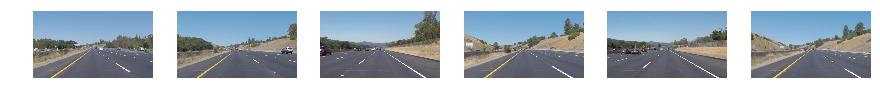

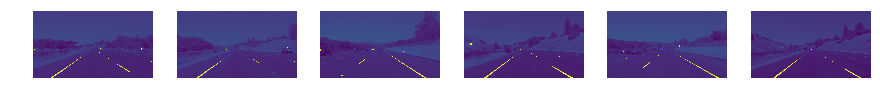

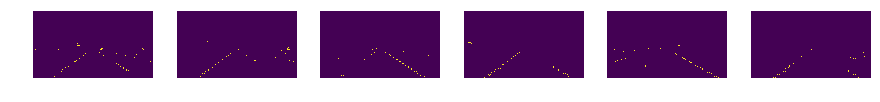

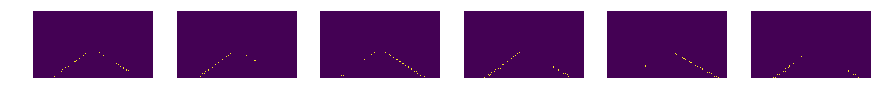

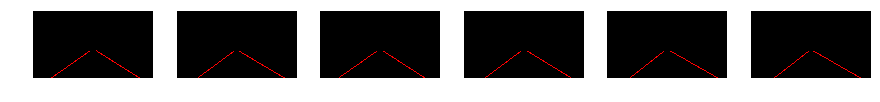

In [5]:

import math, os 
blur_kernal = 5
canny_lower = 60
canny_upper = 110
hough_rho = 3
hough_theta = math.pi / 180
hough_threshold = 70
hough_min_line_len = 40
hough_max_line_gap = 250

dir_path = 'test_images/'
img_list = os.listdir(dir_path)
img_paths = [os.path.join(dir_path, i) for i in img_list]

img_arr = [mpimg.imread(i) for i in img_paths]
img_arr = np.array(img_arr)

img = img_arr[0]
x = img.shape[1]
y = img.shape[0]

vertices = np.array([[(x*0.,y),(x*.475, y*.600), (x*.525, y*.600), (x,y)]], dtype=np.int32)

treated_arr = np.array([treat_color(i) for i in img_arr])
blur_arr = np.array([gaussian_blur(i, blur_kernal) for i in treated_arr])
canny_arr = np.array([canny(i, canny_lower, canny_upper) for i in blur_arr])
poly_arr = np.array([region_of_interest(i, vertices) for i in canny_arr])
hough_arr = np.array([hough_lines(i, hough_rho, hough_theta, hough_threshold, 
                                  hough_min_line_len, hough_max_line_gap) for i in poly_arr])

show_imgs(img_arr)
show_imgs(treated_arr)
show_imgs(canny_arr)
show_imgs(poly_arr)
show_imgs(hough_arr)

## Create image pipeline
The sequence of functions that every picture should go through.

In [6]:
def pipeline(img):

    x = img.shape[1]
    y = img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.6), (x*.525, y*.60), (x,y)]], dtype=np.int32)
    
    img_treated = treat_color(img)
    img_blur = gaussian_blur(img_treated, blur_kernal)
    img_canny = canny(img_blur, canny_lower, canny_upper)
    img_poly = region_of_interest(img_canny, vertices)
    img_hough = hough_lines(img_poly,hough_rho, hough_theta, hough_threshold,
                           hough_min_line_len, hough_max_line_gap)
    final_img = weighted_img(img_hough, img)

    return final_img

## Test on videos

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 21.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.87 s, sys: 400 ms, total: 7.27 s
Wall time: 12.9 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:27<00:00, 24.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 23.7 s, sys: 936 ms, total: 24.6 s
Wall time: 28.6 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Video

Try same algorithm on pavement of different colors and shadows.

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:22<00:00, 15.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 17.6 s, sys: 872 ms, total: 18.5 s
Wall time: 26 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))